<a href="https://colab.research.google.com/github/vanderbilt-data-science/ai_summer/blob/main/1_text_simple_classification_training_solns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning Models
> An introductory example on fine-tuning models

In this walkthrough, we'll explore the standard steps of fine-tuning a model, and we'll apply this towards the intuitive task of text classification.

We'll leverage the [`tweet_eval` dataset](https://huggingface.co/datasets/tweet_eval) to try to classify emotions of tweets into relevant categories.

# Initial Setup

### Install required packages
Note that this is mostly required if you're on Google Colab.

In [1]:
%%capture
! pip install transformers
! pip install datasets

### Import packages of interest

In [2]:
import numpy as np
import pandas as pd

from datasets import load_dataset, load_metric, Dataset
from transformers import pipeline
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

from huggingface_hub import notebook_login

## Log into HuggingFace CLI
Why are we doing this? Below, we'll use our own user accounts to grab datasets and upload models. If we don't do this, we'll have to pass in the auth token over. This isn't bad, but let's streamline our efforts!

In [3]:
!git config --global credential.helper store

In [4]:
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


# Load data from HuggingFace Hub, Datasets, or from disk

In this example, we'll pull from the Huggingface Datasets repository. However, if you have your own dataset, you can use this here. We'll go over how to use your own datasets in future classes.

In [5]:
#Load tweet_eval dataset, emotion configuration
demo_ds = load_dataset('tweet_eval', 'emotion')

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3257 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1421 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/374 [00:00<?, ? examples/s]

Dataset tweet_eval downloaded and prepared to /root/.cache/huggingface/datasets/tweet_eval/emotion/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
# View general structure of data
demo_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3257
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1421
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 374
    })
})

In [7]:
# Look at an example
demo_ds['train'][0]

{'label': 2,
 'text': "“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry"}

In [8]:
# Look at labels
demo_ds['train'].features['label']

ClassLabel(num_classes=4, names=['anger', 'joy', 'optimism', 'sadness'], id=None)

In [9]:
# Create id2label, label2id, and standard info from datasets
num_classes = demo_ds['train'].features['label'].num_classes
id2label = {ind:val for ind, val in enumerate(demo_ds['train'].features['label'].names)}
label2id = {val:key for key, val in id2label.items()}

print(num_classes)
print(id2label)
label2id

4
{0: 'anger', 1: 'joy', 2: 'optimism', 3: 'sadness'}


{'anger': 0, 'joy': 1, 'optimism': 2, 'sadness': 3}

# Pre-process inputs
We've already learned about tokenizers - let's see what this looks like as we approach training. A richer treatment of tokenizers can be found in the Huggingface [instructions on tokenizers](https://huggingface.co/course/chapter2/4?fw=pt). Then, let's try it on our own!

In [10]:
#instantiate tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")
tokenizer.name_or_path

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

'distilbert-base-cased'

In [11]:
#define tokenizing function
def tokenize_inputs(example):
    return tokenizer(example['text'], truncation = True)

In [12]:
#do the tokenizing using map function
tokenized_ds = demo_ds.map(tokenize_inputs, batched=True, remove_columns=['text'])

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [13]:
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 3257
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1421
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 374
    })
})

## An aside on tokenizer functionality
We can do many things with tokenizers to help us to tokenize our data and process it. Let's check out these outputs further.

In [14]:
#check out input IDs
print(tokenized_ds['train']['input_ids'][0])

#compare against the text
print(demo_ds['train']['text'][0])

[101, 789, 160, 1766, 1616, 1110, 170, 1205, 7727, 1113, 170, 2463, 1128, 1336, 1309, 1138, 112, 119, 11882, 11545, 119, 108, 15710, 108, 3645, 108, 3994, 102]
“Worry is a down payment on a problem you may never have'.  Joyce Meyer.  #motivation #leadership #worry


In [15]:
#check out the length of the list of lists
print(len(tokenized_ds['train']['input_ids']))

#check out the length of a single element
print(len(tokenized_ds['train']['input_ids'][0]))

3257
28


In [16]:
#convert input_ids to token representation
input0_tokens = tokenizer.convert_ids_to_tokens(tokenized_ds['train']['input_ids'][0])
print(input0_tokens)

['[CLS]', '“', 'W', '##or', '##ry', 'is', 'a', 'down', 'payment', 'on', 'a', 'problem', 'you', 'may', 'never', 'have', "'", '.', 'Joyce', 'Meyer', '.', '#', 'motivation', '#', 'leadership', '#', 'worry', '[SEP]']


In [17]:
#see what this looks like as a string
print(tokenizer.convert_tokens_to_string(input0_tokens))

#another method directly from the input ids
tokenizer.decode(tokenized_ds['train']['input_ids'][0])

[CLS] “ Worry is a down payment on a problem you may never have '. Joyce Meyer. # motivation # leadership # worry [SEP]


"[CLS] “ Worry is a down payment on a problem you may never have '. Joyce Meyer. # motivation # leadership # worry [SEP]"

In [18]:
#other information about tokenizer
print(tokenizer.vocab_size)

#see actual tokenizer vocab (we've abbreviated here)
#tokenizer.vocab
pd.DataFrame({'tokens': tokenizer.vocab.keys(), 'inds': tokenizer.vocab.values()}).set_index('inds').head(10)

28996


,tokens
inds,
15555,Scene
18102,Auxiliary
27474,##lanche
318,Ś
12117,Genesis
6214,corporate
15685,erect
28478,##ث
26174,##taining


## An aside on dynamically padded batch size
HF has the capacity to dynamically pad your batches such that each input is only as long as any given input in the batch. This helps with memory.You can learn more [here](https://huggingface.co/course/chapter3/2?fw=pt). For now, we'll simply instantiate a data collator and use it during training to demonstrate how we can do this.

In [19]:
#Instantiate data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Model Training Preparation

## Define model and task architecture

In [20]:
# Choose the model type and instantiate it for the task
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-cased",
                                                           num_labels=num_classes,
                                                           id2label=id2label,
                                                           label2id=label2id)

Downloading:   0%|          | 0.00/251M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier

## Consideration of appropriate metrics

What are good metrics for us to use for classification?

### From HF Datasets Metrics
Some metrics are available to us through [HF Datasets Metrics repo](https://huggingface.co/metrics).

In [21]:
#load a metric
metric = load_metric("accuracy")

#define the metric behavior
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

### Custom definitions
We can also define our own. The function inputs are a tuple of logits and labels, and the function must return a dictionary of key-value pairs. The keys should be the name of the metric and the values should be the values of that metric. We'll see an example below.

In [22]:
from sklearn.metrics import precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    
    #get predictions by using index of max logit
    predictions = np.argmax(logits, axis=-1)
    
    #calculate classification report
    perfs = precision_recall_fscore_support(labels, predictions, average='macro', zero_division=0)
    perf_dict = dict(zip(['precision', 'recall', 'fscore'], perfs[:3]))
    
    #return dictionary
    return perf_dict

## Settings for Model Training
Now, let's set some parameters that will govern the training loop of the model training. This includes practical considerations such as:
* Where the model should be saved
* Whether the model should be pushed to hub
* How often to assess the performance of the model on the validation set

As well as settings for neural network training, including:
* Number of epochs to train
* Learning rate
* Optimizer parameters

We do this through [TrainingArguments](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) and the [Trainer class.](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer) Let's take a look!

In [23]:
#set new training arguments
training_args = TrainingArguments("bert-emotion",
                                  logging_strategy = "epoch",
                                  evaluation_strategy="epoch",
                                  save_strategy='epoch',
                                  load_best_model_at_end = True,
                                  metric_for_best_model='fscore',
                                  greater_is_better=True,
                                  per_device_train_batch_size = 4,
                                  per_device_eval_batch_size = 4,
                                  num_train_epochs=3,
                                  push_to_hub=True,
                                  hub_strategy='checkpoint',
                                  report_to='all')

#set data and functionality for trainer
trainer = Trainer(model=model,
                  args=training_args,
                  tokenizer=tokenizer,
                  data_collator=data_collator,
                  train_dataset=tokenized_ds['train'],
                  eval_dataset=tokenized_ds['validation'],
                  compute_metrics=compute_metrics)

# Train model
Now, let's actually train the model!

Below, we'll define a `model_init` function, which allows us to start training from the HF BERT training checkpoint (in other words, we start training from the HF weights we've downloaded).

We borrow this approach from the Tunstall text which allows us clean restarts of training. If we did not take this approach, we would continue modifying the underlying model in place with no record of continuing training.

In [24]:
#define a model init function which will help us just start training fron scratch
def model_init():
  return(AutoModelForSequenceClassification.from_pretrained("distilbert-base-cased",
                                                           num_labels=num_classes,
                                                           id2label=id2label,
                                                           label2id=label2id))

In [25]:
#example of how we can update trainer attributes (note that generally you wouldn't do this unless you're just experimenting around)
trainer.model = None
trainer.model_init = model_init

#actually train the model
trainer.train()

loading configuration file https://huggingface.co/distilbert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/ebe1ea24d11aa664488b8de5b21e33989008ca78f207d4e30ec6350b693f073f.302bfd1b5e031cc1b17796e0b6e5b242ba2045d31d00f97589e12b458ebff27a
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "anger",
    "1": "joy",
    "2": "optimism",
    "3": "sadness"
  },
  "initializer_range": 0.02,
  "label2id": {
    "anger": 0,
    "joy": 1,
    "optimism": 2,
    "sadness": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.19.2",
  "vocab_size": 28996
}

loading weights f

Epoch,Training Loss,Validation Loss,Precision,Recall,Fscore
1,0.856100,0.784438,0.757520,0.608113,0.625340
2,0.533700,0.908023,0.756728,0.723591,0.732531
3,0.257300,1.166988,0.726225,0.725550,0.725308


***** Running Evaluation *****
  Num examples = 374
  Batch size = 4
Saving model checkpoint to bert-emotion/checkpoint-815
Configuration saved in bert-emotion/checkpoint-815/config.json
Model weights saved in bert-emotion/checkpoint-815/pytorch_model.bin
tokenizer config file saved in bert-emotion/checkpoint-815/tokenizer_config.json
Special tokens file saved in bert-emotion/checkpoint-815/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 374
  Batch size = 4
Saving model checkpoint to bert-emotion/checkpoint-1630
Configuration saved in bert-emotion/checkpoint-1630/config.json
Model weights saved in bert-emotion/checkpoint-1630/pytorch_model.bin
tokenizer config file saved in bert-emotion/checkpoint-1630/tokenizer_config.json
Special tokens file saved in bert-emotion/checkpoint-1630/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 374
  Batch size = 4
Saving model checkpoint to bert-emotion/checkpoint-2445
Configuration saved in bert-emotio

TrainOutput(global_step=2445, training_loss=0.5490422535527704, metrics={'train_runtime': 129.3423, 'train_samples_per_second': 75.544, 'train_steps_per_second': 18.903, 'total_flos': 95309811761304.0, 'train_loss': 0.5490422535527704, 'epoch': 3.0})

In [40]:
#it's recommended to push the final version to HF after training completes.
#Note that the code below takes FOREVER depending on the size of your model so you might consider NOT running
#this line until the end of class
trainer.push_to_hub(commit_message='end of training 3 epochs')

Saving model checkpoint to bert-emotion
Configuration saved in bert-emotion/config.json
Model weights saved in bert-emotion/pytorch_model.bin
tokenizer config file saved in bert-emotion/tokenizer_config.json
Special tokens file saved in bert-emotion/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file last-checkpoint/optimizer.pt:   0%|          | 3.34k/502M [00:00<?, ?B/s]

Upload file pytorch_model.bin:   0%|          | 3.34k/251M [00:00<?, ?B/s]

Upload file runs/May20_02-57-05_0f9a3b91efcf/events.out.tfevents.1653015448.0f9a3b91efcf.75.4:  61%|######    …

Upload file last-checkpoint/pytorch_model.bin:   0%|          | 3.34k/251M [00:00<?, ?B/s]

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/charreaubell/bert-emotion
   5a63edc..4fb4d7d  main -> main

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/charreaubell/bert-emotion
   4fb4d7d..a7a2092  main -> main



'https://huggingface.co/charreaubell/bert-emotion/commit/4fb4d7d849762073920aa7936b56844872a6033c'

# Using trained model with `Trainer`


## Evaluate
We can assess the performance of the model over a large number of inputs (e.g., the test set). Here, we initially look at the performance of the training set to make sure the model _can_ learn from the data we've provided.

In [26]:
eval_ds = trainer.evaluate(tokenized_ds['train'])
eval_ds

***** Running Evaluation *****
  Num examples = 3257
  Batch size = 4


{'epoch': 3.0,
 'eval_fscore': 0.9277812331712929,
 'eval_loss': 0.20369768142700195,
 'eval_precision': 0.9390697170516101,
 'eval_recall': 0.9190197699656729,
 'eval_runtime': 7.412,
 'eval_samples_per_second': 439.423,
 'eval_steps_per_second': 109.957}

## Predict
We can also use the model to predict and have the actual logits returned to us. This is helpful if we want to better inspect the performance of the model to consider consistent reasons for misclassifications and ideas on how to improve the performance of our model.

In [27]:
#use trainer to predict
preds = trainer.predict(tokenized_ds['train'])
preds

***** Running Prediction *****
  Num examples = 3257
  Batch size = 4


PredictionOutput(predictions=array([[-1.7088614, -2.0432432,  4.344955 , -1.3081322],
       [ 3.8475218, -1.233819 , -2.553439 , -0.8357121],
       [-1.8148451,  5.1105914, -2.2565951, -1.1808937],
       ...,
       [ 3.5176368, -1.4552178, -1.502886 , -1.4932383],
       [ 4.1719384, -1.9996978, -1.9710643, -1.1405933],
       [ 4.1943946, -2.1744936, -1.846312 , -1.1177405]], dtype=float32), label_ids=array([2, 0, 1, ..., 0, 0, 0]), metrics={'test_loss': 0.20369768142700195, 'test_precision': 0.9390697170516101, 'test_recall': 0.9190197699656729, 'test_fscore': 0.9277812331712929, 'test_runtime': 10.1101, 'test_samples_per_second': 322.152, 'test_steps_per_second': 80.612})

In [28]:
#decide to create a confusion matrix, so import this knowledge
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

,pred_ids,label_ids,text
0,2,2,“Worry is a down payment on a problem you may ...
1,0,0,My roommate: it's okay that we can't spell bec...
2,1,1,No but that's so cute. Atsu was probably shy a...
3,0,0,Rooneys fucking untouchable isn't he? Been fuc...
4,3,3,it's pretty depressing when u hit pan on ur fa...


,pred_ids,label_ids,text,pred_labels,true_labels,is_misclassified
11,0,3,#NewYork: Several #Baloch &amp; Indian activis...,anger,sadness,True
31,2,0,"Jorge deserves it, honestly. He's weak. #90da...",optimism,anger,True
36,3,0,"It'd probably be useful to more than women, bu...",sadness,anger,True
49,3,0,"Tears and eyes can dry but I won't, I'm burnin...",sadness,anger,True
91,2,1,Said it before and I'll say it now: America is...,optimism,joy,True
...,...,...,...,...,...,...
3204,0,3,@user it's Bowers. I went and drove it for a w...,anger,sadness,True
3222,0,3,"2day's most used term is, #terrorism, with man...",anger,sadness,True
3225,3,2,$100 says Teufel is 'reassigned' within the or...,sadness,optimism,True
3227,0,3,#Malaysian police arrest 4 people for suspecte...,anger,sadness,True


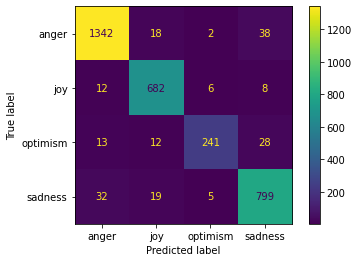

In [29]:
# Create a dataframe for inspection
preds_df = pd.DataFrame({'pred_ids':np.argmax(preds.predictions, axis=-1),
                         'label_ids':preds.label_ids,
                         'text':demo_ds['train']['text']})
display(preds_df.head())

# Populate pred_labels
preds_df['pred_labels'] = preds_df['pred_ids'].replace(id2label)
preds_df['true_labels'] = preds_df['label_ids'].replace(id2label)

# Define misclassified
preds_df['is_misclassified'] = preds_df['pred_ids'] != preds_df['label_ids']
display(preds_df.query('is_misclassified == True'))

# Get confusion matrix
ConfusionMatrixDisplay.from_predictions(preds_df['true_labels'], preds_df['pred_labels'])

In [30]:
#an example of inspecting the results to see examples of incorrect labels
preds_df.query("true_labels=='joy' and pred_labels=='anger'")['text'].tolist()

["@user lol I thought maybe, couldn't decide if there was levity or not",
 'Lady gaga fucking followed i have been waiting for this day for ages it fucking happened im shaking thank you so much @user ❤️',
 "Yo there's a kid on my snap chat from LA &amp; they get high off helium gas lmao.... I am like why the fuck lol",
 "Michelle, who did NOTHING is hating on Nicole's game hahaha.... #bitter #bb18",
 '@user #terrible Paul so deserved that win!!! #bbfail',
 'I like the commercial where @user on a chocolate milk bender, steals a soccer ball from some guys and refuses to give it back. #bully',
 'I like cycling because I get to intimidate people with my powerful calves &amp; horrendous tan lines.',
 "He's mixing it up pretty well..using that slider pretty affective so far #thebabybombers #yankees #offense",
 'whenever i pout i just want Adrian to appear and tell me to stop pouting or else',
 '@user @user @user pretty average, klitschko fury did about 600k and Joshua white did about 450k',


# Using your fine-tuned model
You can use the model that you've saved locally or the model that you've pushed to hub within a pipeline. Let's see how this works.

In [32]:
#create pipeline from your classifier
emotion_classifier = pipeline('text-classification', model='bert-emotion/checkpoint-2445');

#optionally, load from HF
#emotion_classifier = pipeline('text-classification', model='charreaubell/bert-emotion', use_auth_token=True)

#get output
emo = emotion_classifier(['The cat is prettier than any cat I have ever seen.',
                          'Opposums are criminally underrated.'])


loading configuration file bert-emotion/checkpoint-2445/config.json
Model config DistilBertConfig {
  "_name_or_path": "bert-emotion/checkpoint-2445",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "anger",
    "1": "joy",
    "2": "optimism",
    "3": "sadness"
  },
  "initializer_range": 0.02,
  "label2id": {
    "anger": 0,
    "joy": 1,
    "optimism": 2,
    "sadness": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.19.2",
  "vocab_size": 28996
}

loading configuration file bert-emotion/checkpoint-2445/config.json
Model co

In [33]:
#inspect results
emo

[{'label': 'joy', 'score': 0.9983296990394592},
 {'label': 'anger', 'score': 0.9981691837310791}]

# Homework
Now that you've learned the essentials of training, let's take a moment to reflect on what we've learned, augment our knowledge, and avoid some known pitfalls.

## Tokenizers

In [2]:
#@title Tokenizers: Verifying your understanding

#@markdown Make sure to run all the cells in the `Aside on Tokenizer functionality`
#@markdown section to make sure that you understand the encoding and decoding
#@markdown functions.

In [2]:
#@title Updating our tokenization function
#@markdown Using the HF API, HF course, and Tunstall text
#@markdown determine how you would pad each input during tokenization.
#@markdown What methods of padding and truncation are available?

In [1]:
#@title Expanding our knowledge of Datasets `map` method
#@markdown What if we wanted to remove all html from our
#@markdown data prior to tokenization? We can do this with the map
#@markdown of Datasets. Use the following resource from the
#@markdown [HuggingFace Course](https://huggingface.co/course/chapter5/3?fw=pt#the-map-methods-superpowers) to understand how one might
#@markdown go about doing this. Implement this here.

## Training Arguments and the Trainer Class

In [ ]:
#@title `model_init`
#@markdown Recall that we defined a `model_init` function, which we asserted
#@markdown was because we didn't want to continue with undocumented training.
#@markdown You took our word for this, but now you'll explore the perils of
#@markdown this on your own.

#@markdown After copying the cells required for training your model below,
#@markdown make the following changes to the code to explore the behavior.
#@markdown 1. Amend your training arguments by setting `push_to_hub = False`.
#@markdown We're doing this just to reduce the time and efforts required as we're
#@markdown exploring.
#@markdown 2. In the instantiation of the `Trainer` class (i.e., the `trainer = Trainer(...)` lines),
#@markdown set the model parameter to use the model that you created initially (this will likely just be `model=model`,...)
#@markdown as an argument.
#@markdown 3. Amend your Training Arguments to train for only 1 epoch.
#@markdown 4. Train your model. Note the change in performance and inspect the titles of the checkpoint directories.
#@markdown 5. Run the same cell again to continue training your model. Note the change in performance and
#@markdown again inspect the titles of your checkpoint directories.

#@markdown Consider the behavior of the above code in the context of what we experienced
#@markdown with checkpoint directories during class. Answer the following questions:
#@markdown 1. At step 5, how many epochs would we have trained the underlying model for?
#@markdown 2. At step 5, what evidence do you have that you've the model for 2 epochs?
#@markdown 3. Comment on the above question from the standpoint of reproducibility. In other words,
#@markdown let's say you pushed this model to the Hub, and the Model Card makes it appear
#@markdown as if you've trained for one epoch whereas you've actually trained for two.
#@markdown How do you think this will affect others trying to reproduce your results?
#@markdown 4. Comment on the advantages of the `model_init` method during development
#@markdown as we're initially exploring parameters for our models.

In [ ]:
#@title Model metrics
#@markdown Let's say that we wanted to see the precision and recall
#@markdown for each of the individual classes rather than the `macro` averaging
#@markdown as we saw in our current `compute_metrics` function we've written.

#@markdown Using the same sklearn functions (or not, but sklearn may make it easier),
#@markdown return the precision and recall for each individual class label in addition
#@markdown to the macro scores. Recall that what is returned from the `compute_metrics`
#@markdown function must be a dictionary.

In [ ]:
#@title TrainingArguments parameters
#@markdown We've logged, saved, and evaluated at each epoch. However,
#@markdown if we have an extremely large dataset, seeing one or more of these
#@markdown at the end of each epoch (e.g., if it takes 3 hours to make it through
#@markdown a single epoch) may conflict with our desire to monitor our model training.

#@markdown 1. Using the TrainingArguments API, change your model to log, evaluate, and save
#@markdown every 200 steps rather than every epoch.
#@markdown 2. How does this change your checkpointing directories?
#@markdown 3. How does this influence the intervals of evaluation?

## Your research project
You've successfully trained a model - great job!! Now, let's focus on what YOU need to do for your task. What is the task that best describes what you're after? Using the [Transformer Notebooks](https://huggingface.co/docs/transformers/notebooks) and use the `Open in Colab` badge, explore what this task looks like. Note that even if your modality is different, you may be able to directly still use these notebooks with a few changes!